In [1]:
! pip install GPy gpyopt

     |████████████████████████████████| 1.0MB 14.5MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 71kB 12.6MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2626944 sha256=2677902ef17554f37d9ee41a73bedb3d78deb8f2af7284f477f858080080e723
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for gpyopt: filename=GPyOpt-1.2.6-cp37-none-any.whl size=83623 sha256=151c2bbec54888b1046c9017189cce748ebae10ce1e7baa0eb38da9a9f735b3a
  Stored in directory: /root/.cache/pip/wheels/b2/00/69/cfa967a125cf25e66f644be6193ad6f0edf231147879ad714f
  Created wheel for paramz: filename=paramz-0.9.5-cp37-none-any.whl size=102552 sha256=5665651b6417f2e29f4606db8ca582b3458ac51803b3a286b4826215f08fa757
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy gpyopt paramz


In [2]:
%pylab inline  
import GPy
import GPyOpt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from numpy.random import seed
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numba import njit
seed(12354)

Populating the interactive namespace from numpy and matplotlib


## True value

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/My Drive/SCM

/content/drive/My Drive/SCM


In [5]:
# X real - free energy landscape 
dat = pd.read_csv('try_to_estim_1.txt', sep='\t',skiprows=[0,1], header=None)
X_real = np.array(dat[:][1])

# Y real
# Y_pos_real - probability for translocation pos
# Y_neg_real - probability for translocation neg
# rate - num of pos transloctions/ num of all translocations 
dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',skiprows=[0,1], header=None)
dat2.drop(dat2.columns[0], axis = 1, inplace = True)
Y_pos_real = np.array(dat2[:][1])
Y_neg_real = np.array(dat2[:][2])

# Rate real
dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',nrows=1, header=None)
rate_real = float(dat2[11])


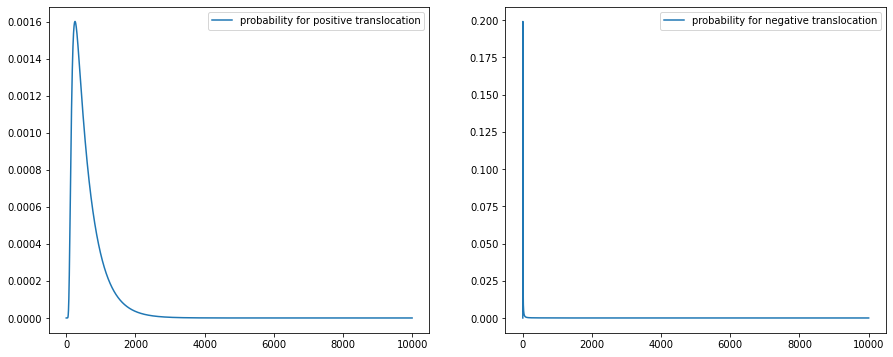

In [6]:
# plots for probability distributions
# 1) successful translocation
# 2) unsuccessful translocation

fig, axes = plt.subplots(1, 2)
axes[0].plot(Y_pos_real, label = 'probability for positive translocation')
axes[0].legend()
axes[1].plot(Y_neg_real, label = 'probability for negative translocation')
axes[1].legend()

fig.set_figwidth(15)    #  ширина и
fig.set_figheight(6)  

plt.show()

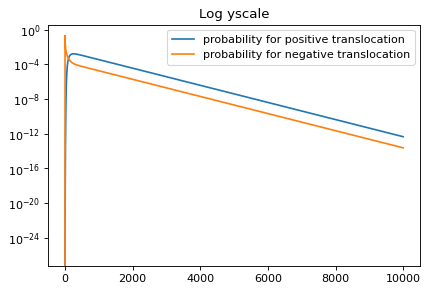

In [7]:
# the same plots but in log scale

plt.figure(dpi = 80)
plt.plot(Y_pos_real, label = 'probability for positive translocation')
plt.legend()

plt.plot(Y_neg_real, label = 'probability for negative translocation')
plt.legend()

plt.yscale('log')
plt.title('Log yscale')
plt.show()

## Usual polynomial approximation

In [ ]:


# parameterizing real value
poly = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
a = np.arange (51)
#b = X_try
b = X_real
poly.fit(a.reshape(-1,1), b)
b_pred = poly.predict(a.reshape(-1,1))
X_parametr_real = np.array(poly.named_steps['linear'].coef_)


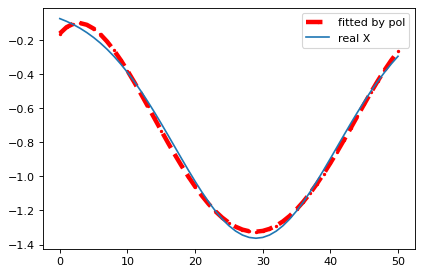

In [ ]:
# Real input X ad parametrized with polynomial function

plt.figure(dpi = 80)
plt.plot(b_pred,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by pol')
plt.plot(X_real, label = 'real X', )
plt.legend()

## Chebyshev polynomial approximation

$
- T_{0}(x)=1 \\
- T_{1}(x)=x\;\\
- T_{2}(x)=2x^{2}-1\;\\
- T_{3}(x)=4x^{3}-3x\;\\
- T_{4}(x)=8x^{4}-8x^{2}+1\;\\
- T_{5}(x)=16x^{5}-20x^{3}+5x\;\\
- T_{6}(x)=32x^{6}-48x^{4}+18x^{2}-1\;\\
- T_{7}(x)=64x^{7}-112x^{5}+56x^{3}-7x\;\\
- T_{8}(x)=128x^{8}-256x^{6}+160x^{4}-32x^{2}+1\;$

$$p(x) = c_0 + c_1 * T_1(x) + ... + c_n * T_n(x)$$


In [8]:
import numpy.polynomial.chebyshev as cheb
p = cheb.Chebyshev.fit(np.arange(51),X_real, 4, window=[0,51])

In [9]:
p

Chebyshev([-1.65655276e-01,  4.59322244e-02, -4.63906577e-03,  7.23447989e-05,
       -3.08507134e-07], domain=[ 0., 50.], window=[ 0., 51.])

In [10]:
X_parametr_real = p.coef

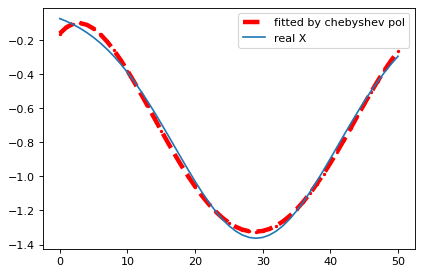

In [11]:
xx, yy = p.linspace(n=51)
plt.figure(dpi = 80)
plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
plt.plot(np.arange(51),X_real,label = 'real X')

plt.legend()

## Initial data

Parametrizing initial distributions (polynomial of 4 degree) - 600 initial data

In [ ]:
import pandas as pd
X = pd.read_csv('X for save').set_index('Unnamed: 0')
import numpy as np
X = np.array(X)
X_parametr_pol = np.zeros([X.shape[0], 5])
for i in range (X.shape[0]):
    poly = Pipeline([('poly', PolynomialFeatures(degree=4)), ('linear', LinearRegression(fit_intercept=False))])
    a = np.arange (51)
    b = X[i]
    #plt.plot(a,b)
    poly.fit(a.reshape(-1,1), b)
    b_pred = poly.predict(a.reshape(-1,1))
    X_parametr_pol[i] = np.array(poly.named_steps['linear'].coef_)

Parametrizing initial distributions (by $\textbf{Chebyshev polynomial}$ of 4 degree) - 600 initial data

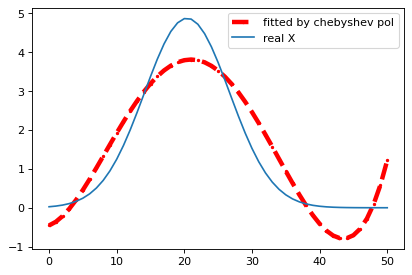

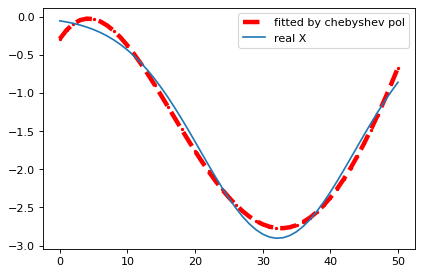

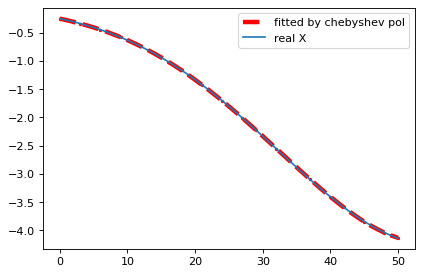

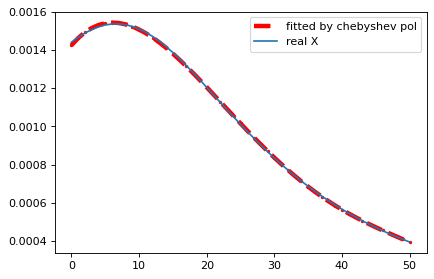

In [12]:
import pandas as pd
X = pd.read_csv('X for save').set_index('Unnamed: 0')
import numpy as np
X = np.array(X)
X_parametr_pol = np.zeros([X.shape[0], 5])
for i in range (X.shape[0]):
    p = cheb.Chebyshev.fit(np.arange(51),X[i], 4, window=[0,51])
    X_parametr_pol[i] = p.coef
    if i % 150 == 0:
      xx, yy = p.linspace(n=51)
      plt.figure(dpi = 80)
      plt.plot(xx, yy,'go--', linewidth=4, markersize=2, color = 'red', label = 'fitted by chebyshev pol')
      plt.plot(np.arange(51),X[i],label = 'real X')

      plt.legend()


### the next 2 cells havn't been used in the progrmam yet but may be in the future 

In [ ]:
Y_pos_new = pd.read_csv('y_pos for save').set_index('Unnamed: 0')
Y_neg_new = pd.read_csv('y_neg for save').set_index('Unnamed: 0')
rate = pd.read_csv('rate for save').set_index('Unnamed: 0')

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import numpy as np
diff_pos = np.zeros(Y_pos_new.shape[0])
diff_neg = np.zeros(Y_pos_new.shape[0])
diff = np.zeros(Y_pos_new.shape[0])
for i in range (len(Y_pos_new)):
  diff_pos[i] = mse(np.log(np.array(Y_pos_new.iloc[i][1:])),np.log(Y_pos_real[1:]))
  #print(diff_pos[i])
  diff_neg[i] = mse(np.log(Y_neg_new.iloc[i][1:]),np.log(Y_neg_real[1:]))
  #print(diff_neg[i])
  diff[i] = diff_pos[i]+ diff_neg[i]

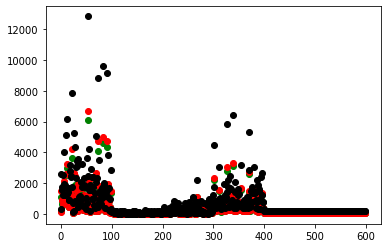

In [ ]:
plt.scatter(np.arange(600),diff_pos, color = 'green')
#plt.title('MSE with positive')
#plt.show()
plt.scatter(np.arange(600),diff_neg, color = 'red')
#plt.title('MSE with negative')
#plt.show()
plt.scatter(np.arange(600),diff, color = 'black')
#plt.title('Neg+pos (1:1)')

## Constructing function for optimization

In [13]:
import subprocess
subprocess.call(["gfortran","-o","outputic","F.f90"]) #just for compile the programm

0

In [28]:
(pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,NaN,N,=,NaN,NaN,NaN,NaN,NaN,50,success,rate=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,time=,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:


def Fokker_plank_eq (x_end):
  
    # real data
    #dat2 = pd.read_csv('try_to_estim_res1.txt', sep=' ',skiprows=[0,1], header=None)
    #dat2.drop(dat2.columns[0], axis = 1, inplace = True)
    #Y_pos_real = np.array(dat2[:][1])
    #Y_neg_real = np.array(dat2[:][2])

    #saving new input data
    N = 51
    t = 1
    num1 = 50000
    f = open('./new_input.txt', 'w')
    f.write(str(N-1) + '\t'+ str(t) + '\n' + str(num1)+ '\t'+ str(t) +'\t' + str(10000)+ '\t'+ str(t) + '\n' )
    x = []
    y = []
    for i in range (N-1):
          #x.append(i)
          #y.append(polynom(i, x_end)[0])
          f.write(str(i) + '\t' + str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))) + '\n')
          #print(str(real(np.polynomial.chebyshev.chebval(i,np.array(x_end)[0]))))
    #x.append(50)
    #y.append(polynom(50, x_end)[0])
    f.write (str(50) + '\t' + str(np.polynomial.chebyshev.chebval(51,np.array(x_end[0]))))
    f.close()
    print(np.array(x_end)[0])
    plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),np.array(x_end)[0]))

    #fortran programm - making new distributions
    subprocess.check_output(["./outputic"])
    #saving new output data
    dat = pd.read_csv('./new_output.txt', sep=' ',skiprows=[0,1], header=None)
    dat.drop(dat.columns[0], axis = 1, inplace = True)
    rate = float(np.array(pd.read_csv('./new_output.txt', sep=' ',nrows=1, header=None)[11]))
    #print(rate)
    #checking for some bugs in the saved new data
    for i in range (1,dat.shape[0]):
        if str(dat[1][i]).find('E')==-1 and str(dat[1][i]).find('e')==-1 and str(dat[1][i]).find('-') !=-1 and str(dat[1][i]).find('nan') == -1:
          dat[1][i] = (str(dat[1][i]).split('-')[0]) + 'E' + '-' + (str(dat[1][i]).split('-')[1])
        if str(dat[1][i]).find('nan') != -1 or float(dat[1][i]) == 0 and i != 0:
          dat[1][i] = dat[1][i-1]
        if str(dat[2][i]).find('E')==-1 and str(dat[2][i]).find('e')==-1 and str(dat[2][i]).find('-') !=-1 and str(dat[2][i]).find('nan') == -1:
          dat[2][i] = (str(dat[2][i]).split('-')[0]) + 'E' + '-' + (str(dat[2][i]).split('-')[1])
        if str(dat[2][i]).find('nan') != -1 or float(dat[2][i]) == 0 and i != 0:
          dat[2][i] = dat[2][i-1]

    Y_pos_new = np.array(dat[1][:], dtype = float)
    Y_neg_new = np.array(dat[2][:], dtype = float)
        

    # mse for minimization
    diff_new =(1-rate)*mse((Y_pos_new[1:]),(Y_pos_real[1:])) + (rate)*mse((Y_neg_new[1:]),(Y_neg_real[1:]))
    return diff_new

In [ ]:
# polynomial function - inverse parametrizing 
@njit
def polynom(x, param):
  param = param.reshape(-1,1)
  return param[0] + x*param[1]+ x**2*param[2]+ x**3*param[3] + x**4*param[4] #+ x**5*param[5] + x**6*param[6] + x**7*param[7] + param[0]

## BO optimization

In [35]:
#bounds for our function

space =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5e-1,5e-1)},
        {'name': 'var_2', 'type': 'continuous', 'domain': (-1e-1,1e-1)}, #2
        {'name': 'var_3', 'type': 'continuous', 'domain': (-1e-2,1e-2)}, #3
        {'name': 'var_4', 'type': 'continuous', 'domain': (-1e-4,1e-4)}, #5
        {'name': 'var_5', 'type': 'continuous', 'domain': (-1e-6,1e-6)}] #7
        
#constraints = [{'name': 'constr_1', 'constraint': '-x[:,1] -.5 + abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'},
              #{'name': 'constr_2', 'constraint': 'x[:,1] +.5 - abs(x[:,0]) - np.sqrt(1-x[:,0]**2)'}]

In [ ]:
GPyOpt.methods.BayesianOptimization?

[-4.40037131e-01  6.15451039e-02  1.49096309e-02 -3.63481927e-04
  2.10321419e-06]
[ 1.24743935e-01  1.54642247e-02 -6.37722703e-03  2.24584369e-04
 -1.61693950e-06]
[ 6.83285364e-01  9.41353766e-02  1.03690184e-03 -5.37807365e-05
  3.31454912e-07]
[-4.20922363e-01  8.24663077e-03  1.52563860e-02 -3.53764082e-04
  2.02472670e-06]
[ 2.90110060e-01 -9.46736556e-03  3.69270523e-03 -6.04084511e-05
  2.52496769e-07]
[ 5.16822470e-01  1.66702565e-02  4.74640261e-03 -9.28122075e-05
  4.39770219e-07]
[ 9.07357013e-02 -3.41768780e-02  1.10920007e-02 -2.31434661e-04
  1.24146704e-06]
[ 3.45132647e-01 -2.46702395e-02  5.14329192e-03 -7.79852651e-05
  3.04861520e-07]
[ 1.87698132e-01 -6.23562241e-02  4.53942883e-03 -4.21879978e-05
  5.57251811e-08]
[ 2.98299406e-01 -3.47104013e-02  5.51365663e-03 -8.67107723e-05
  3.59505760e-07]
[ 7.04902956e-01 -4.14121659e-01  2.46181527e-02 -3.62211474e-04
  1.56180211e-06]
[ 1.48329126e+00 -7.91933120e-01  3.93564788e-02 -5.61707813e-04
  2.43521908e-06]
[ 2.

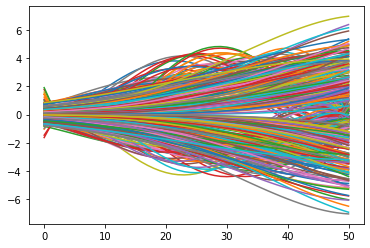

In [57]:
seed(12345)
# BO object
kernel = GPy.kern.RBF(1, 1.5, 2)
model = GPyOpt.models.GPModel(optimize_restarts=3,exact_feval = True, verbose=True) #GP model without noize and with 3 restarts
#model.model = m

myBopt = GPyOpt.methods.BayesianOptimization(f = Fokker_plank_eq,        # function to optimize       
                                             domain = space,        # box-constraints of the problem
                                             #constraints = constraints, we have no constrains
                                             model = model,
                                             X = X_parametr_pol[:400], #возможно, легче самим добавить точки, но это мы еще посмотрим
                                             #Y = diff,
                                             #initial_design_numdata = 20, #number of initial points
                                             #initial_design_type = 'random',
                                             normalize_Y = True,
                                             verbosity = True,
                                             acquisition_type ='MPI') # acquisition = Expected improvement

                              

Optimization restart 1/3, f = 537.9162853608325
Optimization restart 2/3, f = 537.9162853610761
Optimization restart 3/3, f = 537.9162853615505
[ 3.58385924e-03  6.59352646e-03 -2.24801591e-04  6.77710664e-06
 -6.82217498e-09]
Optimization restart 1/3, f = 537.4988291323139
Optimization restart 2/3, f = 537.4988291323166
Optimization restart 3/3, f = 537.4988291336545
[-5.18307362e-03  8.56809410e-03 -3.60935753e-04  8.54616850e-06
  9.44663653e-10]
Optimization restart 1/3, f = 537.1822925112641
Optimization restart 2/3, f = 537.1822925112695
Optimization restart 3/3, f = 537.1822925112724
[ 5.22808014e-03  4.32360662e-03 -1.04633533e-04  3.49445085e-06
  2.18654895e-08]
Optimization restart 1/3, f = 537.4131814264939
Optimization restart 2/3, f = 537.4131814267071
Optimization restart 3/3, f = 537.4131814264596
[-7.07479869e-03  1.01360247e-02 -4.48512224e-04  1.06280605e-05
 -8.92084689e-09]
Optimization restart 1/3, f = 537.1931679114373
Optimization restart 2/3, f = 537.1931679114

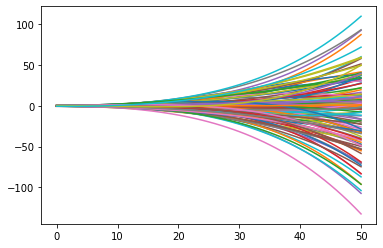

In [58]:
myBopt.run_optimization(150)

In [43]:
#results of optimization
myBopt.x_opt

array([-2.35123178e-01,  4.51096656e-02, -4.93580995e-03,  6.57998492e-05,
       -2.25507018e-07])

In [21]:
X_parametr_real

array([-1.65655276e-01,  4.59322244e-02, -4.63906577e-03,  7.23447989e-05,
       -3.08507134e-07])

### MSE for (1-rate)*mse_true(,) + (rate)*mse_false

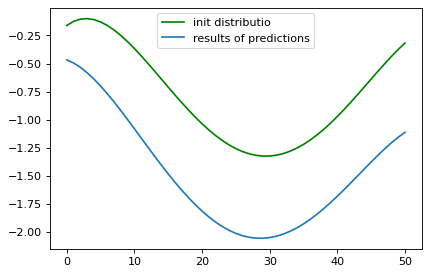

In [59]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (rate)*mse_true(,) + (1-rate)*mse_false

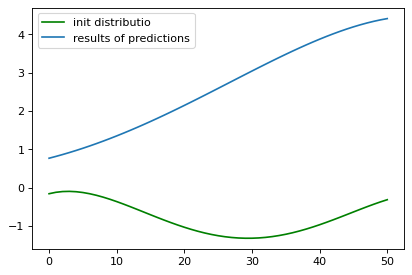

In [53]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (rate)*mse_true(log,log) + (1-rate)*mse_false

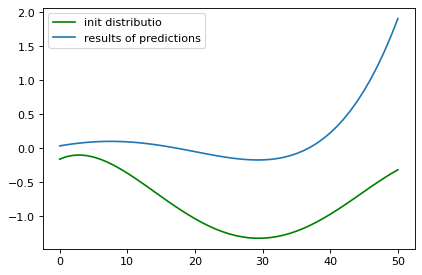

In [49]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

### MSE for (1-rate)*mse_true(log,log) + rate*mse_false

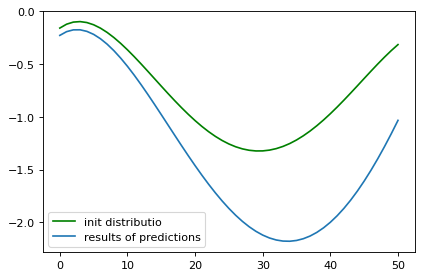

In [45]:
plt.figure(dpi = 80)
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),X_parametr_real), color = 'g', label = 'init distributio')
plt.plot(np.polynomial.chebyshev.chebval(np.arange(51),myBopt.x_opt), label = 'results of predictions', )
plt.legend()

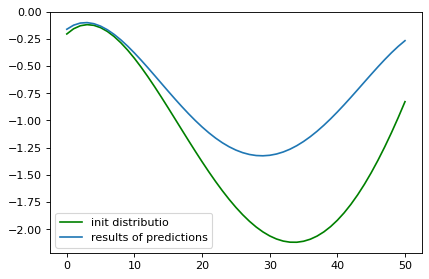

In [ ]:
plt.figure(dpi = 80)
plt.plot(distr, color = 'g', label = 'init distributio')
plt.plot(b_pred, label = 'results of predictions', )
plt.legend()